In [1]:
import numpy as np
from numpy.random import uniform 
from numpy.random import rand, randint, normal
from GeneralFunction import *
from Ship_FCM import *
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime, timedelta

# BATHYMETRIC CLASS
bathymetry = Bathymetry("GEBCO_2014_2D_-75.0_30.0_10.0_55.0.nc")
# WATER DEPTH LIMITATION (m)
DEPTH_LIMIT = -11
# INITIATE WEATHER CLASS
weather_info = WeatherInfo("Metdata_NorthAtlantic_2015-01-01-2015-01-31.mat")
# INITIATE SHIP INFORMATION
ship_info = Ship_FCM()

class GA_position:
    
    def __init__(self, departure, destination, v, delta_t, n, eta):
        '''
        DYNAMIC PROGRAMMING GRID SYSTEM IS USED 
        NO CLASS CONTAINER USED
        '''
        # TOTAL DISTANCE AND INITIAL BEARING
        Total_dist, Init_bearing = greatcircle_inverse(departure[0], departure[1], destination[0], destination[1])
        # K = STAGE NUMBER
        K = np.int(np.ceil(Total_dist / (v * 1.854 * delta_t)))
        # UNIT SPACING
        delta_y = Total_dist * eta / (n - 1)
        x, y = m.gcpoints(departure[0], departure[1], destination[0], destination[1], K)
        longi_c, lati_c = np.array(m(x, y, inverse = True))
        # DISTANCE BETWEEN EACH STAGES
        para_stage = greatcircle_inverse(longi_c[:-1], lati_c[:-1], longi_c[1:], lati_c[1:]).T
        self.nodeset = []
        self.nodeset.append(np.array([longi_c[0], lati_c[0]]))
        self.num = n
        for i in range(1, K - 1):
            temp_brng = greatcircle_point(longi_c[i - 1], lati_c[i - 1], para_stage[i - 1, 0], para_stage[i - 1, 1])[2]
            temp_point1 = greatcircle_point(longi_c[i], lati_c[i], delta_y * (n - 1) / 2, temp_brng + 90)
            temp_point2 = greatcircle_point(longi_c[i], lati_c[i], delta_y * (n - 1) / 2, temp_brng - 90)
            temp_x, temp_y = m.gcpoints(temp_point1[0], temp_point1[1], temp_point2[0], temp_point2[1], n)
            temp_pos =np.array(m(temp_x, temp_y ,inverse = True)).T
            # NODE NUMBER START AT 0
            self.nodeset.append(np.array([tempnode for tempnode in temp_pos]))
        self.nodeset.append(np.array([longi_c[-1], lati_c[-1]]))
        ####
        self.powerrate = np.array([0.5, 0.6, 0.75, 0.85, 1.0])
        #################################################################
            
    def estimation(self, Initial_time, speed):
        length_set = len(self.nodeset)
        length_rate = len(self.powerrate)
        node_ind = [(self.num - 1) / 2 for i in range(length_set - 2)] 
        node_ind.insert(0, 0)
        node_ind.append(0)
        node_ind = np.array(node_ind)
        rate_ind = np.ones(length_set - 1, dtype = np.int) * (length_rate - 1)
        Pos = []
        for i in range(len(node_ind)):
            if i == 0:
                Pos.append(self.nodeset[i])
            elif i == len(node_ind) - 1:
                Pos.append(self.nodeset[i])
            else:
                Pos.append(self.nodeset[i][node_ind[i]])
        Pos = np.array(Pos)
        Heading = []
        Dist = []
        fuel = []
        for i in range(len(Pos) - 1):
            Dist.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[0])
            Heading.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[1])
        Heading = np.array(Heading)
        Dist = np.array(Dist)
        Powerrate = self.powerrate[rate_ind]
        time = Initial_time
        for i in range(len(Pos) - 1):
            Hs = weather_info.hs([Pos[i][1], Pos[i][0], time])        
            wind_U = weather_info.u([Pos[i][1], Pos[i][0], time]) / 0.5144
            wind_V = weather_info.v([Pos[i][1], Pos[i][0], time]) / 0.5144        
            Tp = weather_info.tp([Pos[i][1], Pos[i][0], time])
            head = weather_info.hdg([Pos[i][1], Pos[i][0], time])
            cu = weather_info.cu([Pos[i][1], Pos[i][0], time])
            cv = weather_info.cv([Pos[i][1], Pos[i][0], time])
            # WATER DEPTH
            depth = bathymetry.water_depth(Pos[i])
            v = ship_info.Power_to_speed(speed, Powerrate[i], Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            time = Dist[i] / v / 1.852 + time
#            fuelc = ship_info.weather2fuel(v, Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
#            fuel.append(fuelc[3] * Dist[i] / 1.852)
        
#        return np.sum(fuel), time
        return time
        
        
    def sp_individual(self):
        '''
        CREATE A MEMBER OF POPULATION 
        '''
        
        length_set = len(self.nodeset)
        length_rate = len(self.powerrate)
        if rand() > 0.5:
            sn = randint(0, length_set - 1)
            sno = randint(0,length_set - 1, sn)
            ind = randint(0, length_rate, sn)
            rate_ind = np.ones(length_set - 1, dtype = np.int) * randint(length_rate - 2, length_rate)
            rate_ind[sno] = ind
        else:
            rate_ind = randint(0, length_rate, length_set - 1)
        
        return rate_ind
        
    
    def cp_individual(self):
        #  CHANGE WAYPOINT WITH FIXED POWER
        length_set = len(self.nodeset)
        
        sn1 = randint(0, length_set - 2)
        sno1 = randint(0, length_set - 2, sn1)
        node_ind = np.ones(length_set - 2, dtype = np.int) * (self.num - 1) / 2

        # SELECT POINTS USING NORMAL DISTRIBUTION 
        mean_node = (self.num - 1) / 2
        std_node = float(self.num) / 6
        for i in sno1:
            while True:
                index = int(normal(mean_node, std_node) + 0.5)
                if (index >= 0) & (index < self.num):
                    node_ind[i] = index
                    break
        node_ind = node_ind.tolist()
        node_ind.insert(0, 0)
        node_ind.append(0)
        node_ind = np.array(node_ind)
        
        return node_ind
        
        
        
    def individual(self):
        '''
        CREATE A MEMBER OF POPULATION 
        '''
        
        length_set = len(self.nodeset)
        length_rate = len(self.powerrate)   
        
        sn1 = randint(0, length_set - 2)
        sno1 = randint(0, length_set - 2, sn1)
        node_ind = np.ones(length_set - 2, dtype = np.int) * (self.num - 1) / 2

        # SELECT POINTS USING NORMAL DISTRIBUTION 
        mean_node = (self.num - 1) / 2
        std_node = float(self.num) / 6
        for i in sno1:
            while True:
                index = int(normal(mean_node, std_node) + 0.5)
                if (index >= 0) & (index < self.num):
                    node_ind[i] = index
                    break
        node_ind = node_ind.tolist()
        node_ind.insert(0, 0)
        node_ind.append(0)
        node_ind = np.array(node_ind)
        
        if rand() > 0.5:            
            sn = randint(0, length_set - 1)
            sno = randint(0,length_set - 1, sn)
            rate_ind = np.ones(length_set - 1, dtype = np.int) * randint(length_rate - 2, length_rate)
            rate_ind[sno] = randint(0, length_rate, sn)            
        else:                        
            rate_ind = randint(0, length_rate, length_set - 1)
        
        return [node_ind, rate_ind]
        
        
    def sp_population(self, count):
        
        container = []
        while len(container) < count:
            container.append(self.sp_individual())
        
        return container
    
    
    def cp_population(self, count):
        
        container = []
        while len(container) < count:
        # ADD CONSTRAINTS FOR EACH INDIVIDUALS
            pos = self.cp_individual()
            ind = []
            for i in range(len(pos) - 1):
                if i == 0:
                    ind.append(bathymetry.is_below_depth(self.nodeset[i], self.nodeset[i+1][pos[i+1]], DEPTH_LIMIT))
                elif i == len(pos) - 2:
                    ind.append(bathymetry.is_below_depth(self.nodeset[i][pos[i]], self.nodeset[i+1], DEPTH_LIMIT))
                else:
                    ind.append(bathymetry.is_below_depth(self.nodeset[i][pos[i]], self.nodeset[i+1][pos[i+1]], DEPTH_LIMIT))
            ind = np.array(ind)
            if np.all(ind) == False:
                continue
            else:
                container.append(pos)
        
        return container
    
    
    def population(self, count):
        '''
        CREATE A NUMBER OF INDIVIDUALS
        '''
        container = []
        while len(container) < count:
        # ADD CONSTRAINTS FOR EACH INDIVIDUALS
            individual = self.individual()
            ind = []
            pos = individual[0]
            for i in range(len(pos) - 1):
                if i == 0:
                    ind.append(bathymetry.is_below_depth(self.nodeset[i], self.nodeset[i+1][pos[i+1]], DEPTH_LIMIT))
                elif i == len(pos) - 2:
                    ind.append(bathymetry.is_below_depth(self.nodeset[i][pos[i]], self.nodeset[i+1], DEPTH_LIMIT))
                else:
                    ind.append(bathymetry.is_below_depth(self.nodeset[i][pos[i]], self.nodeset[i+1][pos[i+1]], DEPTH_LIMIT))
            ind = np.array(ind)
            if np.all(ind) == False:
                continue
            else:
                container.append(individual)
        
        return container
        
        
    def sp_fitness(self, individual, Initial_time, speed, ETA, r):
        '''
        HYPOTHESIS AND LEARNING
        '''
        # HEADING
        length_set = len(self.nodeset)
        Posin = [(self.num - 1) / 2 for i in range(length_set - 2)]
        Posin.insert(0, 0)
        Posin.append(0)
        Posin = np.array(Posin)
        
        Pin = individual
        Pos = []
        for i in range(len(Posin)):
            if i == 0:
                Pos.append(self.nodeset[i])
            elif i == len(Posin) - 1:
                Pos.append(self.nodeset[i])
            else:
                Pos.append(self.nodeset[i][Posin[i]])
        Pos = np.array(Pos)
        Heading = []
        Dist = []
        fuel = []
        for i in range(len(Pos) - 1):
            Dist.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[0])
            Heading.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[1])
        Heading = np.array(Heading)
        Dist = np.array(Dist)
        Powerrate = self.powerrate[Pin]
        time = Initial_time
        for i in range(len(Pos) - 1):
            Hs = weather_info.hs([Pos[i][1], Pos[i][0], time])        
            wind_U = weather_info.u([Pos[i][1], Pos[i][0], time]) / 0.5144
            wind_V = weather_info.v([Pos[i][1], Pos[i][0], time]) / 0.5144        
            Tp = weather_info.tp([Pos[i][1], Pos[i][0], time])
            head = weather_info.hdg([Pos[i][1], Pos[i][0], time])
            cu = weather_info.cu([Pos[i][1], Pos[i][0], time])
            cv = weather_info.cv([Pos[i][1], Pos[i][0], time])
            # WATER DEPTH
            depth = bathymetry.water_depth(Pos[i])
            v = ship_info.Power_to_speed(speed, Powerrate[i], Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            fuelc = ship_info.weather2fuel(v, Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            fuel.append(fuelc[3] * Dist[i] / 1.852)
            time = Dist[i] / v / 1.852 + time
        
        if time <= ETA:
            fitness = np.sum(fuel)
        else:
            fitness = np.sum(fuel) + r * (time - ETA)
            
        return fitness
        
        
    def cp_fitness(self, individual, Initial_time, speed, ETA, r):
        # HEADING
        length_set = len(self.nodeset)
        
        Posin = individual        
        Pin = np.ones(length_set - 1, dtype = np.int) * 4
        Pos = []
        for i in range(len(Posin)):
            if i == 0:
                Pos.append(self.nodeset[i])
            elif i == len(Posin) - 1:
                Pos.append(self.nodeset[i])
            else:
                Pos.append(self.nodeset[i][Posin[i]])
        Pos = np.array(Pos)
        Heading = []
        Dist = []
        fuel = []
        for i in range(len(Pos) - 1):
            Dist.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[0])
            Heading.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[1])
        Heading = np.array(Heading)
        Dist = np.array(Dist)
        Powerrate = self.powerrate[Pin]
        time = Initial_time
        for i in range(len(Pos) - 1):
            Hs = weather_info.hs([Pos[i][1], Pos[i][0], time])        
            wind_U = weather_info.u([Pos[i][1], Pos[i][0], time]) / 0.5144
            wind_V = weather_info.v([Pos[i][1], Pos[i][0], time]) / 0.5144        
            Tp = weather_info.tp([Pos[i][1], Pos[i][0], time])
            head = weather_info.hdg([Pos[i][1], Pos[i][0], time])
            cu = weather_info.cu([Pos[i][1], Pos[i][0], time])
            cv = weather_info.cv([Pos[i][1], Pos[i][0], time])
            # WATER DEPTH
            depth = bathymetry.water_depth(Pos[i])
            v = ship_info.Power_to_speed(speed, Powerrate[i], Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            fuelc = ship_info.weather2fuel(v, Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            fuel.append(fuelc[3] * Dist[i] / 1.852)
            time = Dist[i] / v / 1.852 + time
        
        if time <= ETA:
            fitness = np.sum(fuel)
        else:
            fitness = np.sum(fuel) + r * (time - ETA)
            
        return fitness
        
        
    def fitness(self, individual, Initial_time, speed, ETA, r):
        '''
        HYPOTHESIS AND LEARNING
        '''
        # HEADING
        Posin, Pin = individual
        Pos = []
        for i in range(len(Posin)):
            if i == 0:
                Pos.append(self.nodeset[i])
            elif i == len(Posin) - 1:
                Pos.append(self.nodeset[i])
            else:
                Pos.append(self.nodeset[i][Posin[i]])
        Pos = np.array(Pos)
        Heading = []
        Dist = []
        fuel = []
        for i in range(len(Pos) - 1):
            Dist.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[0])
            Heading.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[1])
        Heading = np.array(Heading)
        Dist = np.array(Dist)
        Powerrate = self.powerrate[Pin]
        time = Initial_time
        for i in range(len(Pos) - 1):
            Hs = weather_info.hs([Pos[i][1], Pos[i][0], time])        
            wind_U = weather_info.u([Pos[i][1], Pos[i][0], time]) / 0.5144
            wind_V = weather_info.v([Pos[i][1], Pos[i][0], time]) / 0.5144        
            Tp = weather_info.tp([Pos[i][1], Pos[i][0], time])
            head = weather_info.hdg([Pos[i][1], Pos[i][0], time])
            cu = weather_info.cu([Pos[i][1], Pos[i][0], time])
            cv = weather_info.cv([Pos[i][1], Pos[i][0], time])
            # WATER DEPTH
            depth = bathymetry.water_depth(Pos[i])
            v = ship_info.Power_to_speed(speed, Powerrate[i], Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            fuelc = ship_info.weather2fuel(v, Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            fuel.append(fuelc[3] * Dist[i] / 1.852)
            time = Dist[i] / v / 1.852 + time
        if time <= ETA:
            fitness = np.sum(fuel)
        else:
            fitness = np.sum(fuel) + r * (time - ETA)            
        
        return fitness
        
    def sp_evolve(self, pop, Initial_time, speed, ETA, r, retain = 0.2, random_select = 0.05, mutate = 0.01):
        grade = [(self.sp_fitness(x, Initial_time, speed, ETA, r), x) for x in pop]
        graded = [x[1] for x in sorted(grade, key = lambda tup : tup[0])]
#        result = sum([x[0] for x in sorted(grade, key = lambda tup : tup[0])]) / (len(graded) * 1.0)
        result = [x[0] for x in grade]
        retain_length = int(len(graded) * retain)
        parents = graded[:retain_length]
    
        # RANDOMLY ADD OTHER INDIVIDUALS TO PROMOTE GENETIC DIVERSITY
        for individual in graded[retain_length:]:
            if random_select > rand():
                parents.append(individual)
    
    
        # MUTATE SOME INDIVIDUALS
        for individual in parents:
            if mutate > rand():
                changenum = randint(0, int(len(individual) / 5))
                pos_to_mutate = randint(0, len(individual) - 1, changenum)
                individual[pos_to_mutate] = randint(min(individual), max(individual) + 1, changenum)
    
    
        # CROSSOVER PARENTS TO CREATE CHILDREN
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []
        while len(children) < desired_length:
            male = randint(0, parents_length - 1)
            female = randint(0, parents_length - 1)
            if male != female:
                male = parents[male]
                female = parents[female]
                half = len(male) / 2
                child = male[:half].tolist() + female[half:].tolist()
                child = np.array(child)
                children.append(child)
    
        parents.extend(children)    
    
        return parents, result
        
    
    def cp_evolve(self, pop, Initial_time, speed, ETA, r, retain = 0.2, random_select = 0.05, mutate = 0.01):
        #
        grade = [(self.cp_fitness(x, Initial_time, speed, ETA, r), x) for x in pop]
        graded = [x[1] for x in sorted(grade, key = lambda tup : tup[0])]
#        result = sum([x[0] for x in sorted(grade, key = lambda tup : tup[0])]) / (len(graded) * 1.0)
        result = [x[0] for x in grade]
        retain_length = int(len(graded) * retain)
        parents = graded[:retain_length]
    
        # RANDOMLY ADD OTHER INDIVIDUALS TO PROMOTE GENETIC DIVERSITY
        for individual in graded[retain_length:]:
            if random_select > rand():
                parents.append(individual)
    
    
        # MUTATE SOME INDIVIDUALS
        # SELECT POINTS USING NORMAL DISTRIBUTION 
        mean_node = (self.num - 1) / 2
        std_node = float(self.num) / 6
        for individual in parents:
            if mutate > rand():
                pos_to_mutate = randint(0, len(individual) - 1)
                index = int(normal(mean_node, std_node) + 0.5)
                if (index >= 0) & (index < self.num):
                    individual[pos_to_mutate] = index
                
    
        # CROSSOVER PARENTS TO CREATE CHILDREN
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []
        while len(children) < desired_length:
            male = randint(0, parents_length - 1)
            female = randint(0, parents_length - 1)
            if male != female:
                male = parents[male]
                female = parents[female]
                half = len(male) / 2
                child = male[:half].tolist() + female[half:].tolist()
                child = np.array(child)
                children.append(child)
    
        parents.extend(children)    
    
        return parents, result
    
    def evolve(self, pop, Initial_time, speed, ETA, r, retain = 0.2, random_select = 0.05, mutate = 0.01):
        
        grade = [(self.fitness(x, Initial_time, speed, ETA, r), x) for x in pop]
        graded = [x[1] for x in sorted(grade, key = lambda tup : tup[0])]
        result = [x[0] for x in grade]
        retain_length = int(len(graded) * retain)
        parents = graded[:retain_length]

        # RANDOMLY ADD OTHER INDIVIDUALS TO PROMOTE GENETIC DIVERSITY
        for individual in graded[retain_length:]:
            if random_select > rand():
                parents.append(individual)  
            
        # MUTATE SOME INDIVIDUALS
        # SELECT POINTS USING NORMAL DISTRIBUTION 
        mean_node = (self.num - 1) / 2
        std_node = float(self.num) / 6
        for individual in parents:
            if mutate > rand():
                pos_to_mutate = randint(0, len(individual[0]) - 1)
                index = int(normal(mean_node, std_node) + 0.5)
                if (index >= 0) & (index < self.num):
                    individual[0][pos_to_mutate] = index
                individual[1][pos_to_mutate] =  randint(0, len(self.powerrate))                
        
        
        # CROSSOVER PARENTS TO CREATE CHILDREN
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []
        while len(children) < desired_length:
            male = randint(0, parents_length - 1)
            female = randint(0, parents_length - 1)
            if male != female:
                male = parents[male]
                female = parents[female]
                half = len(male) / 2
                child = male[:half] + female[half:]
                children.append(child)
    
        parents.extend(children)
        
        return parents, result
        
        
    def sp_recursion(self, pop, Initial_time, speed, ETA, r, retain = 0.2, random_select = 0.05, mutate = 0.01):
        #
        container = []
        res = []
        container.append(pop)
        while True:
            pop, result = self.sp_evolve(pop, Initial_time, speed, ETA, r, retain, random_select, mutate)
            container.append(pop)
            res.append(sum(result) / len(pop))
            if np.diff(res).size == 0:
                continue
            else:
                cr = np.diff(res)[-1] / res[-1]
                if cr > 0:
                    container.pop()
                    pop = container[-1]
                    break
                elif abs(cr) < 10e-3:
                    break
                else:
                    continue
        fitness = [self.sp_fitness(x, Initial_time, speed, ETA, r) for x in pop] 
                   
        return pop, fitness
        
    def cp_recursion(self, pop, Initial_time, speed, ETA, r, retain = 0.2, random_select = 0.05, mutate = 0.01):
        #
        container = []
        res = []
        container.append(pop)
        while True:
            pop, result = self.cp_evolve(pop, Initial_time, speed, ETA, r, retain, random_select, mutate)
            container.append(pop)
            res.append(sum(result) / len(pop))
            if np.diff(res).size == 0:
                continue
            else:
                cr = np.diff(res)[-1] / res[-1]
                if cr > 0:
                    container.pop()
                    pop = container[-1]
                    break
                elif abs(cr) < 10e-3:
                    break
                else:
                    continue
        fitness = [self.cp_fitness(x, Initial_time, speed, ETA, r) for x in pop] 
                   
        return pop, fitness
    
    def recursion(self, spnum, pnum, num_loop, Initial_time, speed, r):
        '''
        spnum -- shortest path model population number
        pnum -- population number
        num_loop -- loop number of evolution
        
        '''
        length_set = len(self.nodeset)
#        length_rate = len(self.powerrate)
        node_ind = [(self.num - 1) / 2 for i in range(length_set - 2)] 
        node_ind.insert(0, 0)
        node_ind.append(0)
        node_ind = np.array(node_ind)
        # ESTIMTE TIME ARRIVAL
        ETA = self.estimation(Initial_time, speed) + 10
        # CREATE POPULATION OF SHORTEST PATH
        sp_pop = self.sp_population(spnum)
        # EVOLVE THE POPULATION 
        sp_pop, spfit = self.sp_recursion(sp_pop, Initial_time, speed, ETA, r)
        # CREATE NORMAL POPULATION
        pop = self.population(pnum)
        # PICK OPTIMAL INDIVIDUALS
        num_pick = int(spnum / 10)
        # ADD IT TO POPULATION
        for i in np.argsort(spfit)[0: num_pick]:
            pop.append([node_ind, sp_pop[i]])
        for i in range(num_loop):
            pop, res = self.evolve(pop, Initial_time, speed, ETA, r)
        res = [self.fitness(x, Initial_time, speed, ETA, r) for x in pop]
        
        return pop, res
    
    def retrival_individual(self, individual, Initial_time, speed):
        # RETRIVE DATA FROM INDIVIDUAL
        # HEADING
        Posin, Pin = individual
        Pos = []
        for i in range(len(Posin)):
            if i == 0:
                Pos.append(self.nodeset[i])
            elif i == len(Posin) - 1:
                Pos.append(self.nodeset[i])
            else:
                Pos.append(self.nodeset[i][Posin[i]])
        Pos = np.array(Pos)
        Heading = []
        Dist = []
        fuel = []
        for i in range(len(Pos) - 1):
            Dist.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[0])
            Heading.append(greatcircle_inverse(Pos[i][0], Pos[i][1], Pos[i+1][0], Pos[i+1][1])[1])
        Heading = np.array(Heading)
        Dist = np.array(Dist)
        Powerrate = self.powerrate[Pin]
        time = Initial_time
        info1 = []
        info2 = []
        info2.append(time)
        for i in range(len(Pos) - 1):
            Hs = weather_info.hs([Pos[i][1], Pos[i][0], time])        
            wind_U = weather_info.u([Pos[i][1], Pos[i][0], time]) / 0.5144
            wind_V = weather_info.v([Pos[i][1], Pos[i][0], time]) / 0.5144        
            Tp = weather_info.tp([Pos[i][1], Pos[i][0], time])
            head = weather_info.hdg([Pos[i][1], Pos[i][0], time])
            cu = weather_info.cu([Pos[i][1], Pos[i][0], time])
            cv = weather_info.cv([Pos[i][1], Pos[i][0], time])
            # WATER DEPTH
            depth = bathymetry.water_depth(Pos[i])
            v = ship_info.Power_to_speed(speed, Powerrate[i], Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            fuelc = ship_info.weather2fuel(v, Heading[i], cu, cv, depth, wind_U, wind_V, Hs, Tp, head)
            fuel.append(fuelc[3] * Dist[i] / 1.852)
            time = Dist[i] / v / 1.852 + time
            info1.append([v, fuelc[1], Hs, wind_U, wind_V, Tp, head])
            info2.append(time)
        info1.append([0, 0, 0, 0, 0, 0, 0])
        info = np.column_stack((Pos, info2, info1))
        ## info: [lon, lat, time, speed, Ps, Hs, windU, windV, Tp, head]
        return info

In [2]:
# departure
p_dep = np.array([-5.0, 49.0])
# destination
p_des = np.array([-65.0, 40.0])
# create object
ge = GA_position(p_dep, p_des, 20, 6, 15, 0.2)
  
pop, res = ge.recursion(300, 300, 5, 25, 20, 20000)

In [3]:
ind = np.argsort(res)[0]
best_route = ge.retrival_individual(pop[ind], 25, 20)

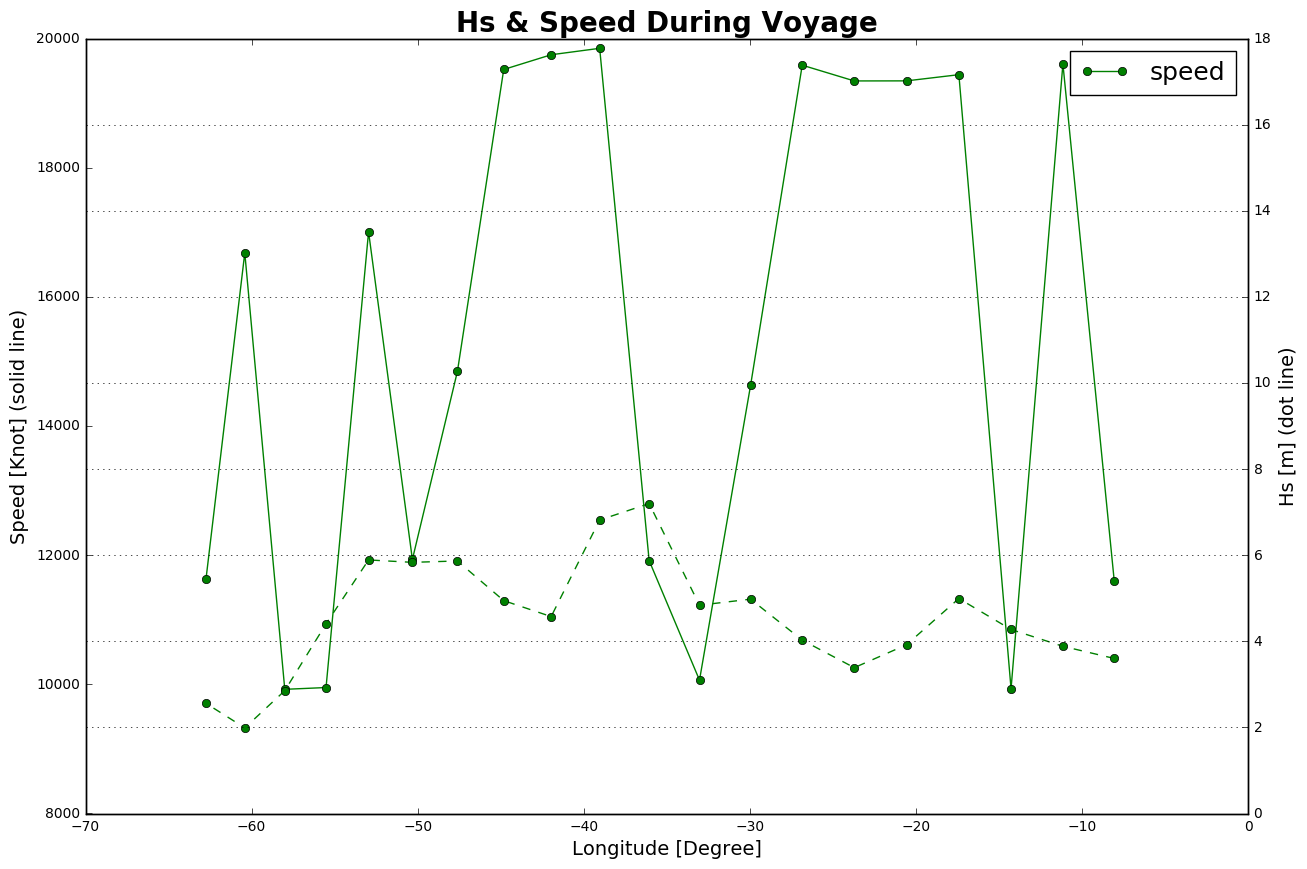

In [10]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()


ax1.set_title("Hs & Speed During Voyage", fontsize = 20, fontweight='bold')
ax1.set_xlabel("Longitude [Degree]", fontsize = 14)
ax1.set_ylabel("Speed [Knot] (solid line)", fontsize = 14)
#ax1.set_ylim([12,21])
ax1.plot(best_route[1:-1,0],best_route[1:-1,4], marker = "o", color = "g", label = "speed")
ax1.legend(loc = 1 ,prop={'size':18})

ax2.set_ylabel("Hs [m] (dot line)", fontsize = 14)
ax2.set_ylim([0,18])
ax2.plot(best_route[1:-1,0], best_route[1:-1,5], marker = "o", color = "g", label = "Hs",linestyle = "--")

plt.grid()

plt.show()